In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time

## Create Initial Emukit Model

In [59]:
num_experiments = 100
parameter_list = ['gamma', 'gradnoise']
parameter_space = ParameterSpace([DiscreteParameter('gamma',list(range(0,25))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [84]:
file_names = ["gradient_latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["gradient_latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [85]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files)
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [86]:
X


array([[20.    ,  0.6015],
       [ 8.    ,  0.3795],
       [23.    ,  0.5053],
       [15.    ,  0.5201],
       [ 0.    ,  0.4757],
       [21.    ,  0.3425],
       [ 1.    ,  0.5497],
       [11.    ,  0.2611],
       [20.    ,  0.4091],
       [ 8.    ,  0.8531],
       [14.    ,  0.7421],
       [19.    ,  0.6237],
       [ 5.    ,  0.8753],
       [ 5.    ,  0.6681],
       [10.    ,  0.5275],
       [ 2.    ,  0.8309],
       [10.    ,  0.3647],
       [17.    ,  0.4535],
       [ 6.    ,  0.8383],
       [12.    ,  0.4905],
       [22.    ,  0.3499],
       [ 6.    ,  0.7199],
       [ 3.    ,  0.3573],
       [23.    ,  0.7125],
       [ 3.    ,  0.3869],
       [21.    ,  0.5867],
       [12.    ,  0.8975],
       [11.    ,  0.8457],
       [14.    ,  0.7865],
       [ 1.    ,  0.9123],
       [ 3.    ,  0.8161],
       [ 6.    ,  0.9641],
       [18.    ,  0.7939],
       [19.    ,  0.3055],
       [ 0.    ,  0.9789],
       [ 4.    ,  0.7717],
       [ 8.    ,  0.7643],
 

In [87]:
Y = get_rewards(data_files,function_at_last_time(single_cell_rate))

In [88]:
len(Y)

100

In [97]:
emukit_model = get_emukit_model(X,Y,lengthscale=2,variance=0.1,noise_var=0.1)

## Plot Gaussian Process Model

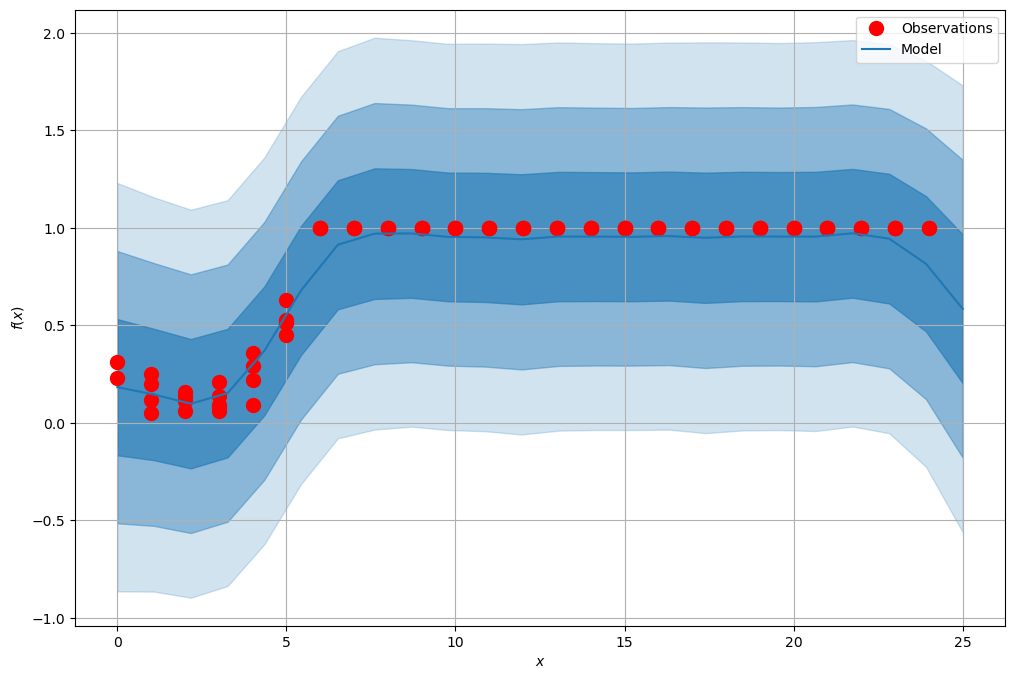

In [98]:
plot_gaussian_process(np.linspace(0,25, 24),0,parameter_space,emukit_model)

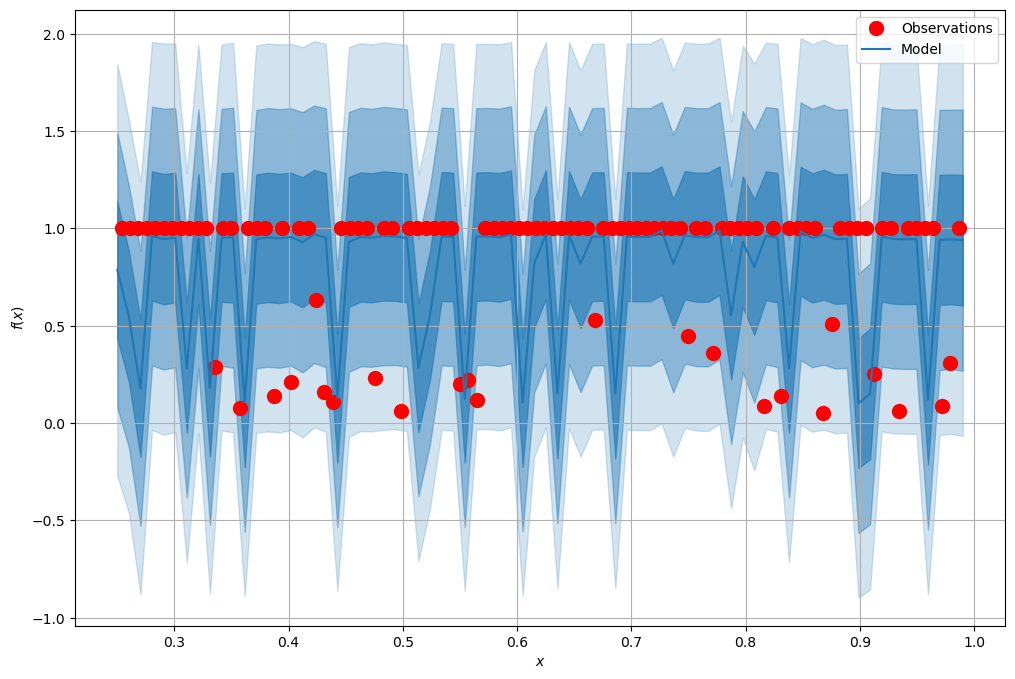

In [99]:
plot_gaussian_process(np.linspace(0.25, 0.99, 74),1,parameter_space,emukit_model)

In [108]:
print(np.array(sorted(np.hstack((X,Y)), key = lambda x : x[2])))


[[ 1.      0.8679  0.05  ]
 [ 2.      0.4979  0.06  ]
 [ 3.      0.9345  0.06  ]
 [ 3.      0.3573  0.08  ]
 [ 3.      0.8161  0.09  ]
 [ 4.      0.9715  0.09  ]
 [ 2.      0.4387  0.11  ]
 [ 1.      0.5645  0.12  ]
 [ 2.      0.8309  0.14  ]
 [ 3.      0.3869  0.14  ]
 [ 2.      0.4313  0.16  ]
 [ 1.      0.5497  0.2   ]
 [ 3.      0.4017  0.21  ]
 [ 4.      0.5571  0.22  ]
 [ 0.      0.4757  0.23  ]
 [ 1.      0.9123  0.25  ]
 [ 4.      0.3351  0.29  ]
 [ 0.      0.9789  0.31  ]
 [ 4.      0.7717  0.36  ]
 [ 5.      0.7495  0.45  ]
 [ 5.      0.8753  0.51  ]
 [ 5.      0.6681  0.53  ]
 [ 5.      0.4239  0.63  ]
 [20.      0.6015  1.    ]
 [ 8.      0.3795  1.    ]
 [23.      0.5053  1.    ]
 [15.      0.5201  1.    ]
 [21.      0.3425  1.    ]
 [11.      0.2611  1.    ]
 [20.      0.4091  1.    ]
 [ 8.      0.8531  1.    ]
 [14.      0.7421  1.    ]
 [19.      0.6237  1.    ]
 [10.      0.5275  1.    ]
 [10.      0.3647  1.    ]
 [17.      0.4535  1.    ]
 [ 6.      0.8383  1.    ]
 

## Perform Sensitivity Analysis

In [ ]:
emukit_model.predict(np.array([[1,1,1]]))

In [ ]:
get_sobol_indices(emukit_model,parameter_space)